# Business Understanding 

# Problem Definition 

## Context

Vaccination is a cornerstone of public health, protecting individuals and communities through both direct immunity and herd immunity. Insights from past campaigns, such as the 2009 H1N1 influenza pandemic, can guide current and future vaccination efforts, including for emerging diseases like COVID-19. Understanding factors influencing vaccine uptake helps public health authorities design targeted interventions to improve coverage.

### Stakeholder
Public health authorities, such as the CDC, are responsible for monitoring vaccine coverage and planning immunization campaigns. Predictive insights from this analysis can help identify populations less likely to get vaccinated and guide resource allocation.

### Problem Statement
This project aims to predict whether an individual received the H1N1 or seasonal flu vaccine based on demographic, behavioral, and opinion-based survey responses. By modeling vaccination likelihood, I can:

1. Identify key factors associated with vaccine uptake.
2. Predict vaccination probability for individuals or populations.
3. Inform targeted public health messaging and interventions.

### Scope and Evaluation
The analysis focuses on one vaccine type (H1N1 or seasonal) and includes:
1. Exploratory Data Analysis (EDA) to understand distributions and relationships.
2. Feature engineering and preprocessing to prepare the data for modeling.
3. Model training using classification algorithms.
4. Evaluation using accuracy, precision, recall, F1-score, and primarily ROC-AUC to measure predictive performance.

### Business Value
Predictive insights enable public health officials to:
1. Identify groups with lower vaccination rates.
2. Design more effective, data-driven vaccination campaigns.
3. Allocate resources efficiently to increase overall vaccine coverage.

## import libraries

In [77]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Load data

In [2]:
# Load CSV files from the data folder
train_features = pd.read_csv('data/training_set_features.csv')
print(train_features.shape)

(26707, 36)


In [3]:
train_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [4]:
train_labels = pd.read_csv('data/training_set_labels.csv')
print(train_labels.shape)

(26707, 3)


In [5]:
train_labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [6]:
test_features = pd.read_csv('data/test_set_features.csv')
print(test_features.shape)

(26708, 36)


In [7]:
test_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"> $75,000",Not Married,Rent,Employed,mlyzmhmf,"MSA, Not Principle City",1.0,0.0,atmlpfrs,hfxkjkmi
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,Non-MSA,3.0,0.0,atmlpfrs,xqwwgdyp
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,"> $75,000",Married,Own,Employed,lrircsnp,Non-MSA,1.0,0.0,nduyfdeo,pvmttkik
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,0.0,NaN,NaN
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,lzgpxyit,Non-MSA,0.0,1.0,fcxhlnwr,mxkfnird


In [8]:
submission_format = pd.read_csv('data/submission_format.csv')
submission_format.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.5,0.7
1,26708,0.5,0.7
2,26709,0.5,0.7
3,26710,0.5,0.7
4,26711,0.5,0.7


In [9]:
print(submission_format.shape)

(26708, 3)


# Exploratory Data Analysis (EDA)

In [10]:
# Check data types
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

## check missing values

In [11]:
# Check missing values
train_features.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [12]:
# Check target distribution
train_labels['h1n1_vaccine'].value_counts()
train_labels['seasonal_vaccine'].value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

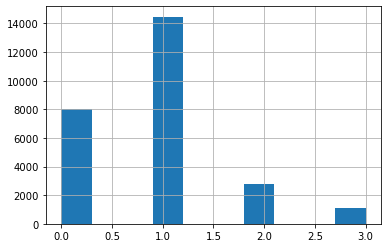

In [13]:
train_features['household_adults'].hist()
plt.show()

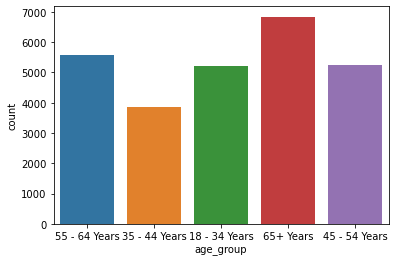

In [14]:
sns.countplot(x='age_group', data=train_features)
plt.show()

In [15]:
# Quick statistics
train_features.describe(include='all')

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,22284,25299,24665,25244,26707,26707,26458.000000,26458.000000,13377,13237
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3,2,2,3,10,3,NaN,NaN,21,23
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"<= $75,000, Above Poverty",Married,Own,Employed,lzgpxyit,"MSA, Not Principle City",NaN,NaN,fcxhlnwr,xtkaffoo
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12777,13555,18736,13560,4297,11645,NaN,NaN,2468,1778
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,NaN,NaN,NaN,NaN,NaN,NaN,0.886499,0.534583,NaN,NaN
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,NaN,NaN,NaN,NaN,NaN,NaN,0.753422,0.928173,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,NaN


# Merging Features and Labels

Combines survey features and vaccination outcomes into a single dataframe. 
This simplifies preprocessing and EDA because all info is in one table.

In [16]:
# merging training_set_features.csv and training_set_labels.csv into one dataframe for cleaning and EDA.
# Merge on respondent_id
train = train_features.merge(train_labels, on='respondent_id')

In [17]:
train.shape

(26707, 38)

In [18]:
train.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Cleaning Column Names

Removes spaces, converts names to lowercase, and standardizes naming. 
This ensures your code won’t break due to typos or inconsistent naming.

In [19]:
#Remove whitespaces
# Clean column names
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_')
train.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

## Cleaning Categorical Values

Converts all categorical entries to lowercase strings

In [20]:
#Cleaning String/Category Values
# Identify categorical columns (example)
categorical_cols = ['age_group', 'education', 'race', 'sex', 'income_poverty', 
                    'marital_status', 'rent_or_own', 'employment_status', 
                    'hhs_geo_region', 'census_msa', 'employment_industry', 
                    'employment_occupation']

# Clean string values
for col in categorical_cols:
    train[col] = train[col].astype(str).str.strip().str.lower()

## Handling Missing Values in categorical
Replaces missing values (NaN) with "unknown" to handle missing data without dropping rows.

In [21]:
#Handling Missing Values
# Fill missing categorical values
for col in categorical_cols:
    train[col] = train[col].replace('nan', 'unknown')

## Handling Missing Values in numerical

In [22]:
# Fill missing numeric values with median
numeric_cols = train.select_dtypes(include='number').columns
train[numeric_cols] = train[numeric_cols].fillna(train[numeric_cols].median())

## Encoding Categorical Features
Converts categories into numerical columns (one-hot encoding). drop_first=True avoids collinearity problems in models like Logistic Regression.

In [23]:
#Encoding Categorical Features
# One-hot encoding for categorical variables
# drop_first=True avoids multicollinearity for linear models
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
train_encoded.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0,0,0,1,0,0,0,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0,0,0,0,0,0,1,0,0,0
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
train_encoded.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
count,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,...,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.619800,1.261392,0.048714,0.727749,0.068933,0.825888,0.357472,0.336279,0.678811,...,0.010334,0.014528,0.013929,0.504362,0.016924,0.013255,0.040514,0.018160,0.066574,0.009286
std,7709.791156,0.909016,0.617047,0.215273,0.445127,0.253345,0.379213,0.479264,0.472444,0.466942,...,0.101133,0.119656,0.117198,0.499990,0.128991,0.114367,0.197164,0.133532,0.249288,0.095917
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# cleaning test_set_features.csv:

In [25]:
# Clean column names
test_features.columns = test_features.columns.str.strip().str.lower().str.replace(' ', '_')

In [26]:
# Clean string values
for col in categorical_cols:
    test_features[col] = test_features[col].astype(str).str.strip().str.lower()

In [27]:
# Fill missing categorical values
for col in categorical_cols:
    test_features[col] = test_features[col].replace('nan', 'unknown')

In [28]:
# Fill numeric missing values
numeric_cols_test = test_features.select_dtypes(include='number').columns
test_features[numeric_cols_test] = test_features[numeric_cols_test].fillna(test_features[numeric_cols_test].median())

## CHECK FOR IMBALANCE

In [29]:
train_encoded.value_counts()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  behavioral_large_gatherings  behavioral_outside_home  behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  chronic_med_condition  child_under_6_months  health_worker  health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  opinion_seas_risk  opinion_seas_sick_from_vacc  household_adults  household_children  h1n1_vaccine  seasonal_vaccine  age_group_35 - 44 years  age_group_45 - 54 years  age_group_55 - 64 years  age_group_65+ years  education_< 12 years  education_college graduate  education_some college  education_unknown  race_hispanic  race_other or multiple  race_white  sex_male  income_poverty_> $75,000  income_poverty_below poverty  income_poverty_unknown  marital_status_not married  marital_status_unknown  rent_or_own_rent  rent_or_own_unknown  employment_status_not

In [30]:
train_encoded.value_counts(normalize=True)

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  behavioral_large_gatherings  behavioral_outside_home  behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  chronic_med_condition  child_under_6_months  health_worker  health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  opinion_seas_risk  opinion_seas_sick_from_vacc  household_adults  household_children  h1n1_vaccine  seasonal_vaccine  age_group_35 - 44 years  age_group_45 - 54 years  age_group_55 - 64 years  age_group_65+ years  education_< 12 years  education_college graduate  education_some college  education_unknown  race_hispanic  race_other or multiple  race_white  sex_male  income_poverty_> $75,000  income_poverty_below poverty  income_poverty_unknown  marital_status_not married  marital_status_unknown  rent_or_own_rent  rent_or_own_unknown  employment_status_not

## COLUMN DATA TYPES

In [31]:
train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Columns: 103 entries, respondent_id to employment_occupation_xzmlyyjv
dtypes: float64(23), int64(3), uint8(77)
memory usage: 7.5 MB


# Preprocessing

In [32]:
# One-hot encoding
test_encoded = pd.get_dummies(test_features, columns=categorical_cols, drop_first=True)

## One-hot encoding

Ensures the test set has exactly the same features as the training set. 
Missing dummy columns in the test set are filled with 0.

In [33]:
#Align train and test columns
train_encoded, test_encoded = train_encoded.align(test_encoded, join='left', axis=1, fill_value=0)

In [34]:
#Verify shapes
print(train_encoded.shape)
print(test_encoded.shape)

(26707, 103)
(26708, 103)


In [35]:
#load the dataset
# Make a copy of the dataframe
df = test_encoded.copy()
# Check the first few rows
df.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_unknown,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
0,26707,2.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,26708,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,26709,2.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,26710,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
4,26711,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Correlation
visualize the correlation between features in your dataset using a heatmap

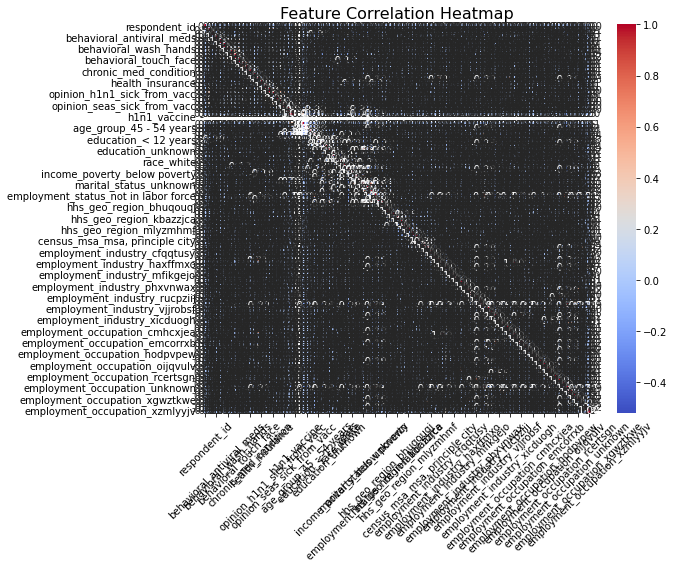

In [36]:
# Select only numeric columns
numeric_df = df.select_dtypes(include='number')

# Compute correlation
corr = numeric_df.corr()

# Set figure size BEFORE plotting
plt.figure(figsize=(10,8))  # adjust width & height as needed

# Plot heatmap
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)

plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)  # rotate x labels for readability
plt.yticks(rotation=0)   # keep y labels horizontal
plt.tight_layout()       # adjust layout so nothing is cut off
plt.show()

## Summarise

In [37]:
#concise stat
df.describe().T

,count,mean,std,min,25%,50%,75%,max
respondent_id,26708.0,40060.500000,7710.079831,26707.0,33383.75,40060.5,46737.25,53414.0
h1n1_concern,26708.0,1.624345,0.901567,0.0,1.00,2.0,2.00,3.0
h1n1_knowledge,26708.0,1.264827,0.614471,0.0,1.00,1.0,2.00,2.0
behavioral_antiviral_meds,26708.0,0.049498,0.216910,0.0,0.00,0.0,0.00,1.0
behavioral_avoidance,26708.0,0.731953,0.442951,0.0,0.00,1.0,1.00,1.0
...,...,...,...,...,...,...,...,...
employment_occupation_vlluhbov,26708.0,0.012169,0.109640,0.0,0.00,0.0,0.00,1.0
employment_occupation_xgwztkwe,26708.0,0.042609,0.201978,0.0,0.00,0.0,0.00,1.0
employment_occupation_xqwwgdyp,26708.0,0.017785,0.132171,0.0,0.00,0.0,0.00,1.0
employment_occupation_xtkaffoo,26708.0,0.065449,0.247320,0.0,0.00,0.0,0.00,1.0


## Check for unique values

In [38]:
#check unique values
for i in df.columns:
    uniq_val = df[i].unique()
    print(f'Column name: {i}\n, {uniq_val}\n')
    print("****"*20) 

Column name: respondent_id
, [26707 26708 26709 ... 53412 53413 53414]

********************************************************************************
Column name: h1n1_concern
, [2. 1. 3. 0.]

********************************************************************************
Column name: h1n1_knowledge
, [2. 1. 0.]

********************************************************************************
Column name: behavioral_antiviral_meds
, [0. 1.]

********************************************************************************
Column name: behavioral_avoidance
, [1. 0.]

********************************************************************************
Column name: behavioral_face_mask
, [0. 1.]

********************************************************************************
Column name: behavioral_wash_hands
, [1. 0.]

********************************************************************************
Column name: behavioral_large_gatherings
, [1. 0.]

**************************************

Column name: employment_occupation_xgwztkwe
, [0 1]

********************************************************************************
Column name: employment_occupation_xqwwgdyp
, [0 1]

********************************************************************************
Column name: employment_occupation_xtkaffoo
, [0 1]

********************************************************************************
Column name: employment_occupation_xzmlyyjv
, [0 1]

********************************************************************************


## Selecting features and target

In [39]:
# Target variables
target = 'h1n1_vaccine'  # or 'seasonal_vaccine'
X = train_encoded.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y = train_encoded[target]

## Train Test Split data

Creates training and validation sets. 
stratify=y ensures the proportion of vaccinated vs non-vaccinated is the same in both sets, preventing bias in evaluation.

In [40]:
#split data into train and test set
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Target variable: {target}")
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Target variable: h1n1_vaccine
Training samples: 21365, Validation samples: 5342


In [41]:
X_train.shape, y_train.shape

((21365, 100), (21365,))

In [42]:
X_val.shape, y_val.shape

((5342, 100), (5342,))

## scale the features

Thecode ensures that all your features are on the same scale, which improves model stability, convergence, and performance, especially for algorithms sensitive to feature magnitude.

In [43]:
# Initialize scaler
sc = StandardScaler()

# Scale the features
X_train_s = sc.fit_transform(X_train)  # fit on training data
X_val_s = sc.transform(X_val)          # transform validation data

# Baseline Model: Logistic Regression

Baseline model using a simple, interpretable algorithm.
Predicts probability of vaccination.

In [44]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [45]:
#check training score
train_score = log_model.score(X_train, y_train)
print(f'{train_score:.2f}')

0.84


In [46]:
# Get model coefficients and parameters properly
coef_ = log_model.coef_
intercept_ = log_model.intercept_
m1_LRM_params = log_model.get_params()

# Optional: store all results together
results = {
    "train_score": log_model.score(X_train, y_train),
    "coef_": coef_,
    "intercept_": intercept_,
    "params": m1_LRM_params
}

# Display results
print("Training Score:", results["train_score"])
print("Coefficients:", results["coef_"])
print("Intercept:", results["intercept_"])
print("Model Parameters:", results["params"])


Training Score: 0.8376784460566347
Coefficients: [[-9.26411635e-02  1.27158423e-01  1.86639594e-01  1.03021876e-02
   2.03605554e-01  4.07991975e-02 -2.49181708e-01  4.74162893e-03
   1.69035698e-02  1.94334247e+00 -4.45432408e-01  1.28937281e-01
   2.90337379e-01  7.07135929e-01  1.27018950e-01  6.37927744e-01
   3.76916466e-01 -7.62798881e-03  9.38388773e-02  1.40605366e-01
  -7.53609902e-02  1.05047943e-02 -6.99168890e-02  2.12807772e-03
   1.15200595e-02  2.93705295e-01  4.43427762e-01 -1.73378183e-01
   1.20681488e-01  3.71357235e-02  2.94654714e-01  3.10704177e-01
   3.06469704e-01  2.52517894e-01  1.47500247e-01  9.25918011e-02
   1.05182176e-01  1.66096063e-01 -1.12614694e-01 -3.07852053e-01
  -6.05337714e-02  1.32274327e-01  1.64470684e-01  1.46014474e-01
   2.80950904e-01  1.62395219e-02 -9.96495306e-02 -1.45391012e-01
  -9.31106820e-02 -2.67112310e-02 -1.56297940e-01  9.70917664e-02
   8.29518473e-02 -1.78829214e-02  7.37594171e-02  8.77753727e-02
  -4.39399817e-01 -5.494060

In [47]:
m1_LRM_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [48]:
#made prediction
# Predictions
y_pred_log = log_model.predict(X_val)
y_pred_proba_log = log_model.predict_proba(X_val)[:, 1]

In [49]:
# Evaluate
roc_auc_log = roc_auc_score(y_val, y_pred_proba_log)
print("Logistic Regression ROC-AUC:", round(roc_auc_log, 3))
print(classification_report(y_val, y_pred_log))

Logistic Regression ROC-AUC: 0.829
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      4207
           1       0.68      0.44      0.53      1135

    accuracy                           0.84      5342
   macro avg       0.77      0.69      0.72      5342
weighted avg       0.82      0.84      0.82      5342



## Check model metrics

In [50]:
accuracy = accuracy_score(y_val, y_pred_log)
cm = confusion_matrix(y_val, y_pred_log)

print("Accuracy:", round(accuracy, 3))
print("Confusion Matrix:\n", cm)

Accuracy: 0.837
Confusion Matrix:
 [[3970  237]
 [ 634  501]]


# Second Model: Random Forest (Tuned)

Random Forest is an ensemble model that handles nonlinearities and interactions.
GridSearchCV tunes hyperparameters to maximize ROC-AUC.

In [51]:
# Choose your single target for the MVP
target = 'h1n1_vaccine'

# Define X and y
X = train_encoded.drop(['h1n1_vaccine', 'seasonal_vaccine', 'respondent_id'], axis=1)
y = train_encoded[target]

# Check alignment
print(X.shape, y.shape)

# Split train/test with matching rows
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, y_train.shape)

(26707, 100) (26707,)
(21365, 100) (21365,)


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize model
rf = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    rf, param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Get best model
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)


Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [53]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)

y_proba_rf = rf.predict_proba(X_val)[:, 1]
y_pred_rf = rf.predict(X_val)

print("Random Forest ROC-AUC:", round(roc_auc_score(y_val, y_proba_rf), 3))
print(classification_report(y_val, y_pred_rf))


Random Forest ROC-AUC: 0.824
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      4207
           1       0.69      0.39      0.50      1135

    accuracy                           0.83      5342
   macro avg       0.77      0.67      0.70      5342
weighted avg       0.82      0.83      0.81      5342



# Evaluate Random Forest

Random Forest ROC-AUC: 0.827

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      4207
           1       0.70      0.39      0.50      1135

    accuracy                           0.83      5342
   macro avg       0.78      0.67      0.70      5342
weighted avg       0.82      0.83      0.82      5342



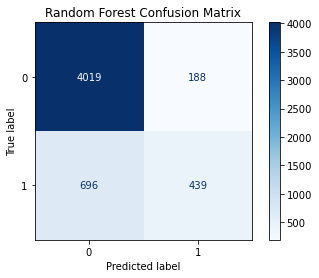

In [54]:
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"Random Forest ROC-AUC: {roc_auc_rf:.3f}\n")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=[0, 1], cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Feature Importance
Identifies which survey questions and demographic factors most influence vaccination prediction.

In [61]:
# Extract feature importance
feat_imp = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Show top 15 features
top_features = feat_imp.head(15)
print("\nTop 15 Important Features:\n", top_features)



Top 15 Important Features:
 doctor_recc_h1n1               0.145510
opinion_h1n1_risk              0.094231
opinion_h1n1_vacc_effective    0.080778
opinion_seas_risk              0.048623
opinion_seas_vacc_effective    0.030828
doctor_recc_seasonal           0.028085
opinion_h1n1_sick_from_vacc    0.027250
h1n1_concern                   0.026468
opinion_seas_sick_from_vacc    0.023685
health_worker                  0.021171
h1n1_knowledge                 0.019768
household_adults               0.019363
household_children             0.017954
sex_male                       0.012876
chronic_med_condition          0.012696
dtype: float64


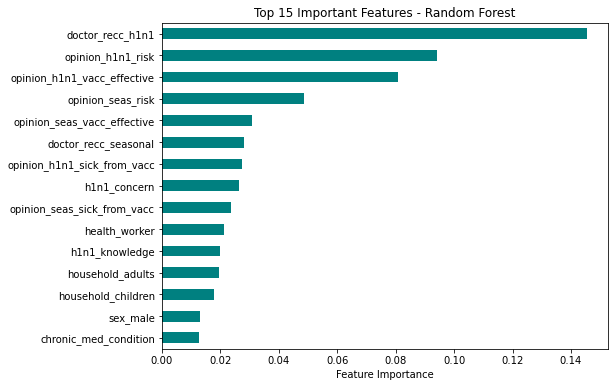

In [62]:
# Plot from the feature importance
top_features.plot(kind='barh', figsize=(8,6), color='teal')
plt.gca().invert_yaxis()
plt.title("Top 15 Important Features - Random Forest")
plt.xlabel("Feature Importance")
plt.show()

In [63]:
# Define features once
feature_cols = train_encoded.drop(['respondent_id','h1n1_vaccine','seasonal_vaccine'], axis=1).columns
X_train = train_encoded[feature_cols]
X_test_final = test_encoded[feature_cols]

# Targets
y_train = train_encoded[['h1n1_vaccine','seasonal_vaccine']]

# Split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Multi-output Logistic Regression
model = MultiOutputClassifier(LogisticRegression(max_iter=500, random_state=42))
model.fit(X_tr, y_tr)

# Predict & evaluate
y_val_pred = model.predict_proba(X_val)
auc_h1n1 = roc_auc_score(y_val['h1n1_vaccine'], y_val_pred[0][:,1])
auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred[1][:,1])
print("ROC AUC H1N1:", auc_h1n1)
print("ROC AUC Seasonal:", auc_seasonal)

ROC AUC H1N1: 0.8390167844865228
ROC AUC Seasonal: 0.8541684035719034


## Multi variable Logistic Regression
Simultaneously predicts H1N1 and seasonal flu vaccination probabilities.
Produces probabilities, not just 0/1 predictions → useful for risk stratification and campaign targeting.

In [64]:
#multi-label binary classification
model = MultiOutputClassifier(LogisticRegression(max_iter=500))
model.fit(X_tr, y_tr)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=500))

In [65]:
# Predict probabilities
y_val_pred = model.predict_proba(X_val)

In [66]:
# Calculate ROC AUC for each target
auc_h1n1 = roc_auc_score(y_val['h1n1_vaccine'], y_val_pred[0][:,1])
auc_seasonal = roc_auc_score(y_val['seasonal_vaccine'], y_val_pred[1][:,1])
print("ROC AUC H1N1:", auc_h1n1)
print("ROC AUC Seasonal:", auc_seasonal)

ROC AUC H1N1: 0.8390167844865228
ROC AUC Seasonal: 0.8541684035719034


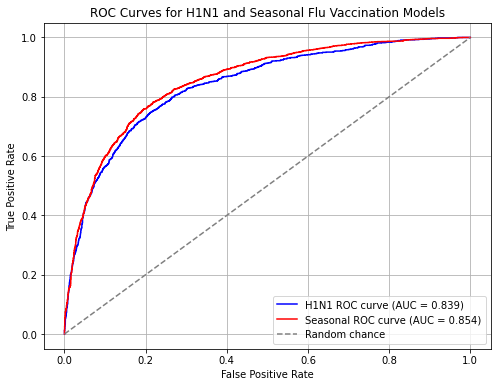

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predicted probabilities from multi-output model
y_val_pred_h1n1 = y_val_pred[0][:, 1]        # probability of H1N1 = 1
y_val_pred_seasonal = y_val_pred[1][:, 1]    # probability of Seasonal = 1

# True labels
y_true_h1n1 = y_val['h1n1_vaccine']
y_true_seasonal = y_val['seasonal_vaccine']

# Compute ROC curves
fpr_h1n1, tpr_h1n1, _ = roc_curve(y_true_h1n1, y_val_pred_h1n1)
roc_auc_h1n1 = auc(fpr_h1n1, tpr_h1n1)

fpr_seasonal, tpr_seasonal, _ = roc_curve(y_true_seasonal, y_val_pred_seasonal)
roc_auc_seasonal = auc(fpr_seasonal, tpr_seasonal)

# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot(fpr_h1n1, tpr_h1n1, color='blue', label=f'H1N1 ROC curve (AUC = {roc_auc_h1n1:.3f})')
plt.plot(fpr_seasonal, tpr_seasonal, color='red', label=f'Seasonal ROC curve (AUC = {roc_auc_seasonal:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random chance')
plt.title('ROC Curves for H1N1 and Seasonal Flu Vaccination Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Submission Preparation
Creates a properly formatted CSV for submission. Probabilities reflect likelihood of vaccination.

In [68]:
# Select only feature columns used for training (drop target and ID)
feature_cols = train_encoded.drop(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1).columns

# Ensure X_test_final has exactly the same columns
X_test_final = test_encoded[feature_cols]

# Now make predictions
y_test_pred = model.predict_proba(X_test_final)

# Prepare submission
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],  # keep ID for submission
    'h1n1_vaccine': y_test_pred[0][:,1],
    'seasonal_vaccine': y_test_pred[1][:,1]
})

submission.to_csv('h1n1_submission.csv', index=False)

In [69]:
submission.head()   # shows the first 5 rows

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.057308,0.324698
1,26708,0.046922,0.046295
2,26709,0.439784,0.611302
3,26710,0.472413,0.881804
4,26711,0.159684,0.478808


In [70]:
submission.tail()   # shows the last 5 rows

,respondent_id,h1n1_vaccine,seasonal_vaccine
26703,53410,0.362473,0.525328
26704,53411,0.095898,0.285726
26705,53412,0.141684,0.196481
26706,53413,0.061649,0.363512
26707,53414,0.471430,0.480426


In [71]:
submission.shape    # check the number of rows and columns

(26708, 3)

In [72]:
# Read back the CSV to verify
pd.read_csv('h1n1_submission.csv').head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.057308,0.324698
1,26708,0.046922,0.046295
2,26709,0.439784,0.611302
3,26710,0.472413,0.881804
4,26711,0.159684,0.478808


## Visualization
Plots distribution of predicted probabilities → shows how certain the model is for each respondent.

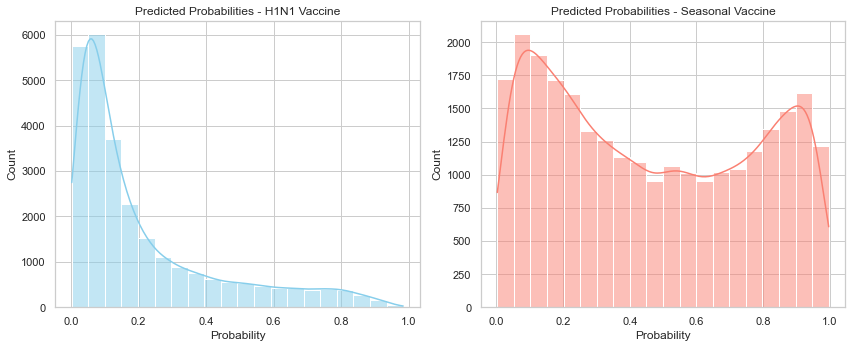

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(12,5))

# h1n1_vaccine probabilities
plt.subplot(1, 2, 1)
sns.histplot(submission['h1n1_vaccine'], bins=20, kde=True, color='skyblue')
plt.title('Predicted Probabilities - H1N1 Vaccine')
plt.xlabel('Probability')
plt.ylabel('Count')

# seasonal_vaccine probabilities
plt.subplot(1, 2, 2)
sns.histplot(submission['seasonal_vaccine'], bins=20, kde=True, color='salmon')
plt.title('Predicted Probabilities - Seasonal Vaccine')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

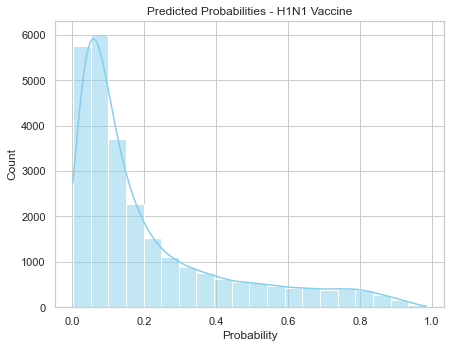

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(12,5))

# h1n1_vaccine probabilities
plt.subplot(1, 2, 1)
sns.histplot(submission['h1n1_vaccine'], bins=20, kde=True, color='skyblue')
plt.title('Predicted Probabilities - H1N1 Vaccine')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

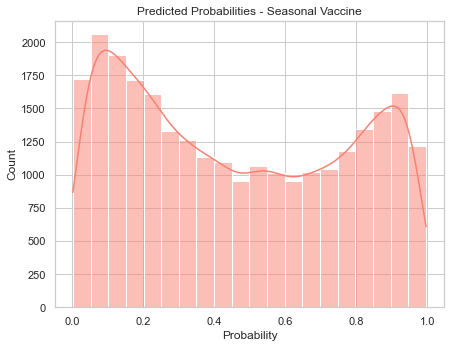

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot histograms
plt.figure(figsize=(12,5))

# seasonal_vaccine probabilities
plt.subplot(1, 2, 2)
sns.histplot(submission['seasonal_vaccine'], bins=20, kde=True, color='salmon')
plt.title('Predicted Probabilities - Seasonal Vaccine')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.tight_layout()
plt.show()